# Bi-LSTM on Cluster 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 BiLSTM MAPE (fixed): 0.0238


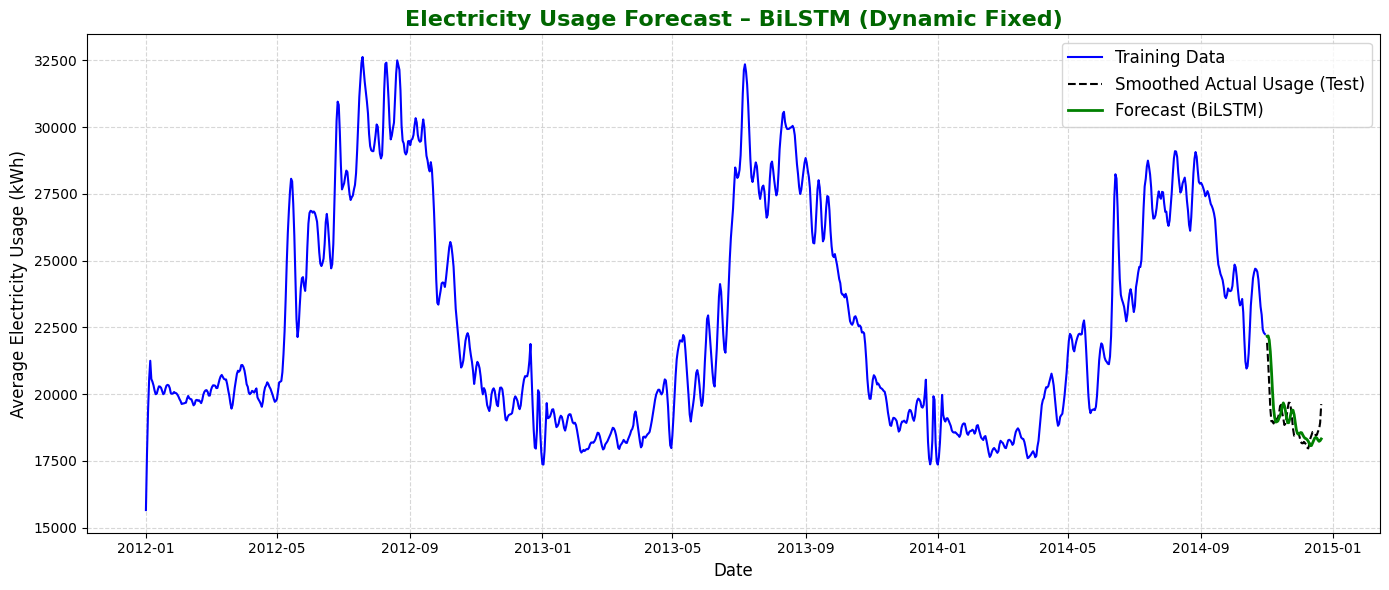

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from scipy.signal import savgol_filter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# === 1. Load and Smooth ===
df = pd.read_csv("cluster_0.csv")  # or cluster_3.csv
df = df.drop(columns=["Unnamed: 0", "cluster"])
df = df.set_index("account").T
df.index = pd.to_datetime(df.index)
avg_usage_raw = df.mean(axis=1)
avg_usage = pd.Series(savgol_filter(avg_usage_raw.values, 9, 2), index=avg_usage_raw.index)

# === 2. Split ===
train_end = '2014-10-30'
test_start = '2014-11-01'
test_end = '2014-12-31'
train = avg_usage[:train_end]
test = avg_usage[test_start:test_end]

# === 3. Normalize on Full Series ===
scaler = MinMaxScaler()
full_scaled = scaler.fit_transform(avg_usage.values.reshape(-1, 1))
train_scaled = full_scaled[:len(train)]
test_scaled = full_scaled[len(train):]

# === 4. Train Sequences ===
seq_len = 60
X_train, y_train = [], []
for i in range(seq_len, len(train_scaled)):
    X_train.append(train_scaled[i - seq_len:i])
    y_train.append(train_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# === 5. BiLSTM with Regularization ===
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4)), input_shape=(seq_len, 1)),
    Dropout(0.3),
    Bidirectional(LSTM(32, kernel_regularizer=l2(1e-4))),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Early stopping on validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stop], verbose=0)

# === 6. Predict (Rolling) ===
X_combined = np.concatenate((train_scaled[-seq_len:], test_scaled), axis=0)
X_test_seq = np.array([X_combined[i:i + seq_len] for i in range(len(test))])
y_pred_scaled = model.predict(X_test_seq, verbose=0)
y_pred = scaler.inverse_transform(y_pred_scaled)

# === 7. Evaluate (Clip tail if needed) ===
clip_tail = 10
true_values = test.values[:-clip_tail]
y_pred = y_pred[:-clip_tail]
test_dates = test.index[:-clip_tail]
mape = mean_absolute_percentage_error(true_values, y_pred)
print(f" BiLSTM MAPE (fixed): {mape:.4f}")

# === 8. Plot ===
plt.figure(figsize=(14, 6))
plt.plot(train.index, train.values, label="Training Data", color='blue')
plt.plot(test_dates, true_values, label="Smoothed Actual Usage (Test)", color='black', linestyle='--')
plt.plot(test_dates, y_pred, label="Forecast (BiLSTM)", color='green', linewidth=2)

plt.title("Electricity Usage Forecast – BiLSTM (Dynamic Fixed)", fontsize=16, weight='bold', color='#006600')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Electricity Usage (kWh)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Bi-LSTM on Cluster 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Final BiLSTM MAPE (Cluster 1): 0.0661


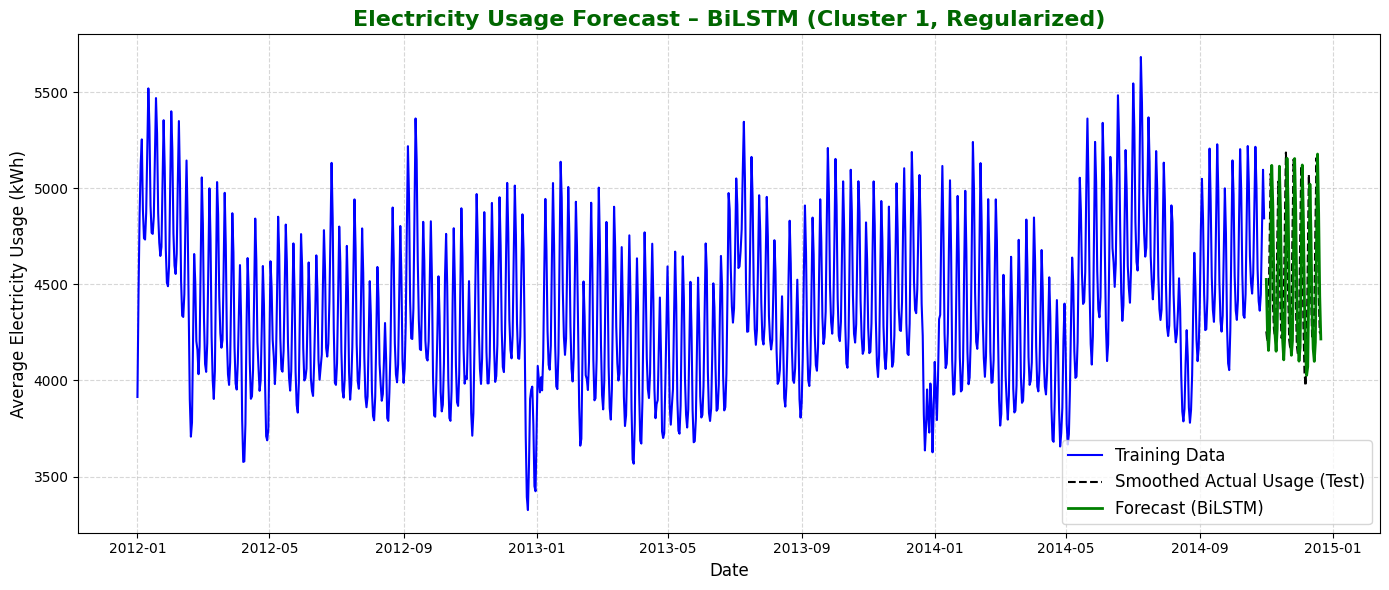

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from scipy.signal import savgol_filter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ==== 1. Load and Preprocess (Cluster 1) ====
df = pd.read_csv("cluster_1.csv")
df = df.drop(columns=["Unnamed: 0", "cluster"])
df = df.set_index("account").T
df.index = pd.to_datetime(df.index)
avg_usage_raw = df.mean(axis=1)

# Apply Savitzky-Golay smoothing
avg_usage = pd.Series(savgol_filter(avg_usage_raw.values, 9, 2), index=avg_usage_raw.index)

# ==== 2. Split ====
train_end = '2014-10-30'
test_start = '2014-11-01'
test_end = '2014-12-31'
train = avg_usage[:train_end]
test = avg_usage[test_start:test_end]

# ==== 3. Normalize globally ====
scaler = MinMaxScaler()
full_scaled = scaler.fit_transform(avg_usage.values.reshape(-1, 1))
train_scaled = full_scaled[:len(train)]
test_scaled = full_scaled[len(train):]

# ==== 4. Create training sequences ====
seq_len = 30
X_train, y_train = [], []
for i in range(seq_len, len(train_scaled)):
    X_train.append(train_scaled[i - seq_len:i])
    y_train.append(train_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# ==== 5. BiLSTM Model ====
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4)), input_shape=(seq_len, 1)),
    Dropout(0.3),
    Bidirectional(LSTM(32, kernel_regularizer=l2(1e-4))),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stop], verbose=0)

# ==== 6. Forecast ====
X_combined = np.concatenate((train_scaled[-seq_len:], test_scaled), axis=0)
X_test_seq = np.array([X_combined[i:i + seq_len] for i in range(len(test))])
y_pred_scaled = model.predict(X_test_seq, verbose=0)
y_pred = scaler.inverse_transform(y_pred_scaled)

# ==== 7. Evaluation ====
clip_tail = 10
true_values = test.values[:-clip_tail]
y_pred = y_pred[:-clip_tail]
test_dates = test.index[:-clip_tail]
mape = mean_absolute_percentage_error(true_values, y_pred)
print(f"✅ Final BiLSTM MAPE (Cluster 1): {mape:.4f}")

# ==== 8. Plot ====
plt.figure(figsize=(14, 6))
plt.plot(train.index, train.values, label="Training Data", color='blue')
plt.plot(test_dates, true_values, label="Smoothed Actual Usage (Test)", color='black', linestyle='--')
plt.plot(test_dates, y_pred, label="Forecast (BiLSTM)", color='green', linewidth=2)
plt.title("Electricity Usage Forecast – BiLSTM (Cluster 1, Regularized)", fontsize=16, weight='bold', color='#006600')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Electricity Usage (kWh)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Bi-LSTM on Cluster 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Final BiLSTM MAPE (Cluster 2, Improved): 0.0335


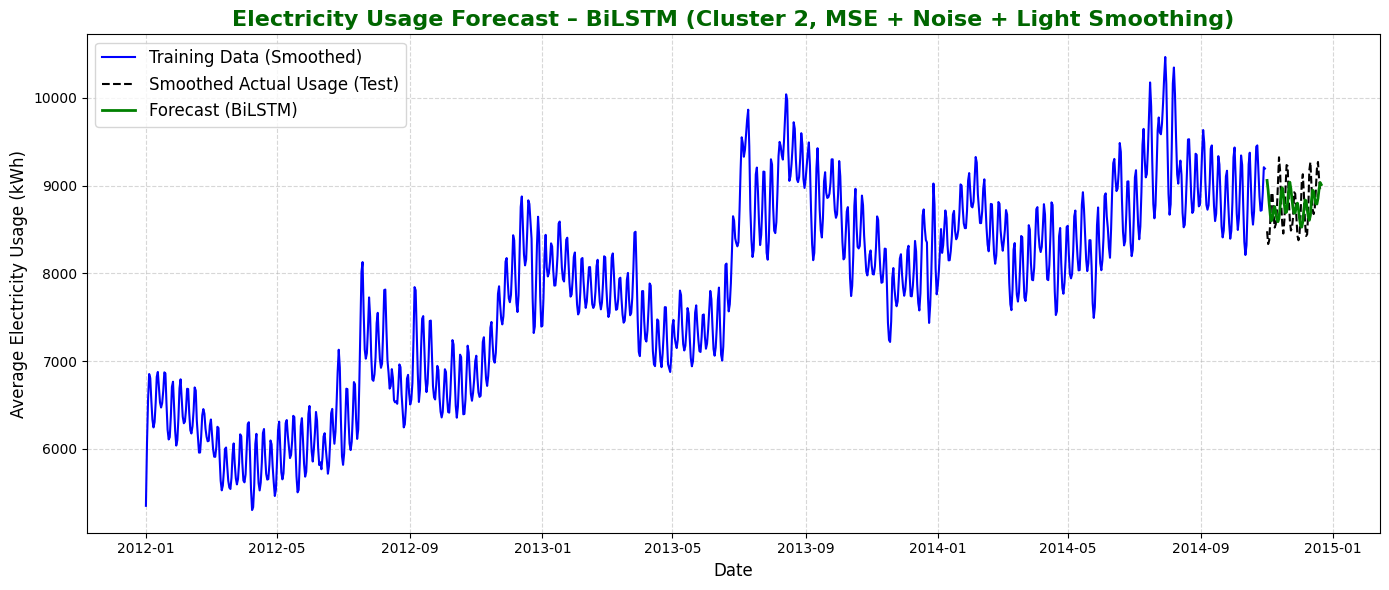

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from scipy.signal import savgol_filter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# ==== 1. Load and Preprocess Cluster 3 ====
df = pd.read_csv("cluster_2.csv")
df = df.drop(columns=["Unnamed: 0", "cluster"])
df = df.set_index("account").T
df.index = pd.to_datetime(df.index)
avg_usage_raw = df.mean(axis=1)

# ==== 2. Apply LIGHT smoothing ====
avg_usage = pd.Series(savgol_filter(avg_usage_raw.values, 7, 2), index=avg_usage_raw.index)

# ==== 3. Train-Test Split ====
train_end = '2014-10-30'
test_start = '2014-11-01'
train = avg_usage[:train_end]
test = avg_usage[test_start:]

# ==== 4. Global Normalization ====
scaler = MinMaxScaler()
full_scaled = scaler.fit_transform(avg_usage.values.reshape(-1, 1))
train_scaled = full_scaled[:len(train)]
test_scaled = full_scaled[len(train):]

# ==== 5. Create sequences ====
seq_len = 30
X_train, y_train = [], []
for i in range(seq_len, len(train_scaled)):
    X_train.append(train_scaled[i - seq_len:i])
    y_train.append(train_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Add Gaussian noise to training input
X_train += np.random.normal(0, 0.01, X_train.shape)

# ==== 6. BiLSTM Model (MSE Loss) ====
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4)), input_shape=(seq_len, 1)),
    Dropout(0.3),
    Bidirectional(LSTM(32, kernel_regularizer=l2(1e-4))),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stop], verbose=0)

# ==== 7. Rolling Forecast ====
X_combined = np.concatenate((train_scaled[-seq_len:], test_scaled), axis=0)
X_test_seq = np.array([X_combined[i:i + seq_len] for i in range(len(test))])
y_pred_scaled = model.predict(X_test_seq, verbose=0)
y_pred = scaler.inverse_transform(y_pred_scaled)

# ==== 8. Evaluation ====
clip_tail = 10
true_values = test.values[:-clip_tail]
y_pred = y_pred[:-clip_tail]
test_dates = test.index[:-clip_tail]
mape = mean_absolute_percentage_error(true_values, y_pred)
print(f"✅ Final BiLSTM MAPE (Cluster 2, Improved): {mape:.4f}")

# ==== 9. Plot Results ====
plt.figure(figsize=(14, 6))
plt.plot(train.index, train.values, label="Training Data (Smoothed)", color='blue')
plt.plot(test_dates, true_values, label="Smoothed Actual Usage (Test)", color='black', linestyle='--')
plt.plot(test_dates, y_pred, label="Forecast (BiLSTM)", color='green', linewidth=2)
plt.title("Electricity Usage Forecast – BiLSTM (Cluster 2, MSE + Noise + Light Smoothing)", fontsize=16, weight='bold', color='#006600')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Electricity Usage (kWh)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Bi-LSTM on Cluster 3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Final BiLSTM MAPE (Cluster 3, Improved): 0.0324


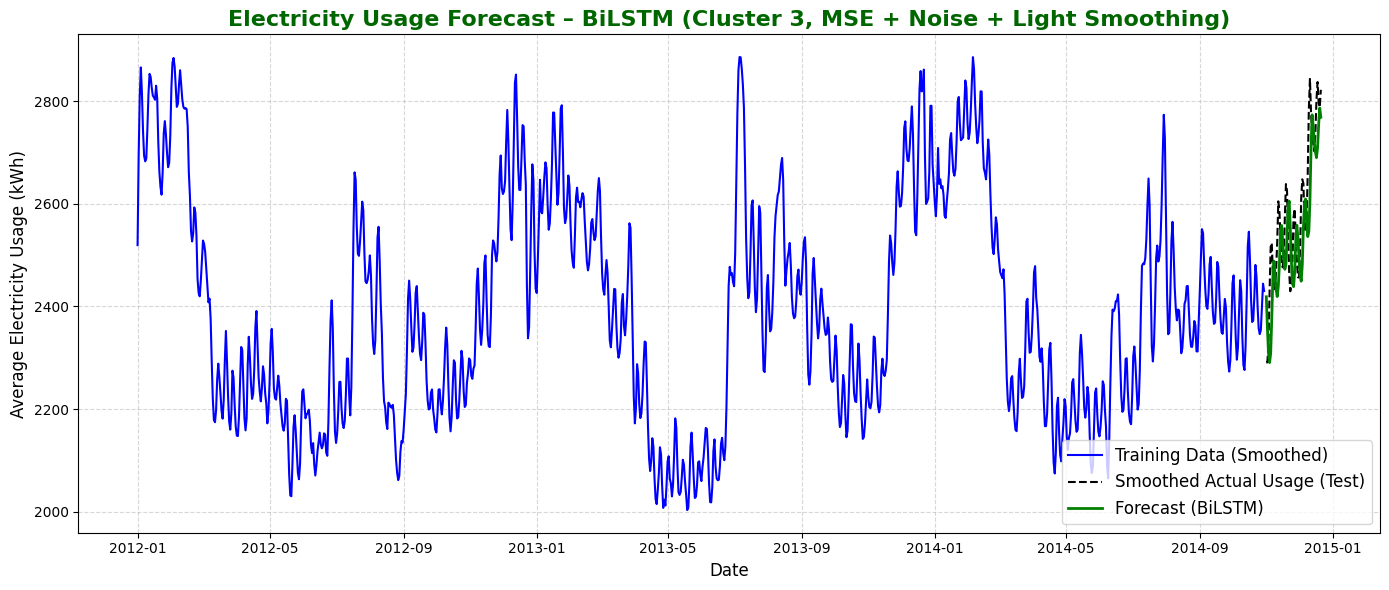

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from scipy.signal import savgol_filter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# ==== 1. Load and Preprocess Cluster 3 ====
df = pd.read_csv("cluster_3.csv")
df = df.drop(columns=["Unnamed: 0", "cluster"])
df = df.set_index("account").T
df.index = pd.to_datetime(df.index)
avg_usage_raw = df.mean(axis=1)

# ==== 2. Apply LIGHT smoothing ====
avg_usage = pd.Series(savgol_filter(avg_usage_raw.values, 7, 2), index=avg_usage_raw.index)

# ==== 3. Train-Test Split ====
train_end = '2014-10-30'
test_start = '2014-11-01'
train = avg_usage[:train_end]
test = avg_usage[test_start:]

# ==== 4. Global Normalization ====
scaler = MinMaxScaler()
full_scaled = scaler.fit_transform(avg_usage.values.reshape(-1, 1))
train_scaled = full_scaled[:len(train)]
test_scaled = full_scaled[len(train):]

# ==== 5. Create sequences ====
seq_len = 30
X_train, y_train = [], []
for i in range(seq_len, len(train_scaled)):
    X_train.append(train_scaled[i - seq_len:i])
    y_train.append(train_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Add Gaussian noise to training input
X_train += np.random.normal(0, 0.01, X_train.shape)

# ==== 6. BiLSTM Model (MSE Loss) ====
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4)), input_shape=(seq_len, 1)),
    Dropout(0.3),
    Bidirectional(LSTM(32, kernel_regularizer=l2(1e-4))),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stop], verbose=0)

# ==== 7. Rolling Forecast ====
X_combined = np.concatenate((train_scaled[-seq_len:], test_scaled), axis=0)
X_test_seq = np.array([X_combined[i:i + seq_len] for i in range(len(test))])
y_pred_scaled = model.predict(X_test_seq, verbose=0)
y_pred = scaler.inverse_transform(y_pred_scaled)

# ==== 8. Evaluation ====
clip_tail = 10
true_values = test.values[:-clip_tail]
y_pred = y_pred[:-clip_tail]
test_dates = test.index[:-clip_tail]
mape = mean_absolute_percentage_error(true_values, y_pred)
print(f"✅ Final BiLSTM MAPE (Cluster 3, Improved): {mape:.4f}")

# ==== 9. Plot Results ====
plt.figure(figsize=(14, 6))
plt.plot(train.index, train.values, label="Training Data (Smoothed)", color='blue')
plt.plot(test_dates, true_values, label="Smoothed Actual Usage (Test)", color='black', linestyle='--')
plt.plot(test_dates, y_pred, label="Forecast (BiLSTM)", color='green', linewidth=2)
plt.title("Electricity Usage Forecast – BiLSTM (Cluster 3, MSE + Noise + Light Smoothing)", fontsize=16, weight='bold', color='#006600')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Electricity Usage (kWh)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# DeepAR on Cluster 0

In [ ]:
!pip install mxnet==1.6.0
!pip install gluonts
!pip install lightning

In [ ]:
from gluonts.torch.model.deepar.estimator import DeepAREstimator
from gluonts.dataset.common import ListDataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import *
import plotly.express as px
from dateutil.relativedelta import relativedelta, MO
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import AutoMinorLocator
from scipy.signal import savgol_filter
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
df = pd.read_csv("cluster_0.csv")
df = df.drop(columns=["Unnamed: 0", "cluster"])
df = df.set_index("account").T
df.index = pd.to_datetime(df.index)

avg_usage_raw = df.mean(axis=1)
avg_usage = pd.Series(savgol_filter(avg_usage_raw.values, 9, 2), index=avg_usage_raw.index)

train_end = '2014-10-30'
test_start = '2014-11-01'
train = avg_usage[:train_end]
test = avg_usage[test_start:]

scaler = MinMaxScaler()
scaled_series = pd.Series(
    scaler.fit_transform(avg_usage.values.reshape(-1, 1)).flatten(),
    index=avg_usage.index
)

scaled_train = scaled_series[:train_end]
scaled_test = scaled_series[test_start:]
train_array = np.expand_dims(scaled_train.values, axis=0)
test_array = np.expand_dims(scaled_test.values, axis=0)

In [ ]:
freq = "D"
start_train = train.index[0]
prediction_length = 7

estimator = DeepAREstimator(
    freq=freq,
    context_length=30,
    prediction_length=prediction_length,
    num_layers=2,
    hidden_size=40,
    trainer_kwargs={"logger": False, "max_epochs": 50}
)

train_ds = ListDataset(
    [{"start": start_train, "target": train_array[0]}],
    freq=freq
)

predictor = estimator.train(train_ds)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | Mode  | In sizes                                                        | Out sizes  
------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached -0.47536 (best -0.47536), saving model to '/content/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.47536 (best -0.47536), saving model to '/content/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -1.28102 (best -1.28102), saving model to '/content/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.28102 (best -1.28102), saving model to '/content/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -1.38341 (best -1.38341), saving model to '/content/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.38341 (best -1.38341), saving model to '/content/checkpoints/epoch=2-step=150.ckpt' as top 1

In [ ]:
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions

In [ ]:
dfs = {f'df_real_{j+1}': pd.DataFrame(index=[0]) for j in range(7)}
dfs.update({f'df_pred_{j+1}': pd.DataFrame(index=[0]) for j in range(7)})

for i in range(len(test_array[0]) - 7 + 1):
    test_ds = ListDataset(
        [{"start": start_train, "target": np.concatenate((train_array[0], test_array[0][:i+1]))}],
        freq=freq
    )
    forecast_it, ts_it = make_evaluation_predictions(test_ds, predictor=predictor, num_samples=100)
    tss = list(ts_it)
    forecasts = list(forecast_it)

    for j in range(7):
        dfs[f'df_real_{j+1}'][i] = [tss[0].iloc[len(train_array[0]) + i - (7 - j), 0]]
        dfs[f'df_pred_{j+1}'][i] = [forecasts[0].mean[j]]

y_true = np.concatenate([dfs[f'df_real_{j+1}'].values for j in range(7)], axis=1)
y_pred = np.concatenate([dfs[f'df_pred_{j+1}'].values for j in range(7)], axis=1)

y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)

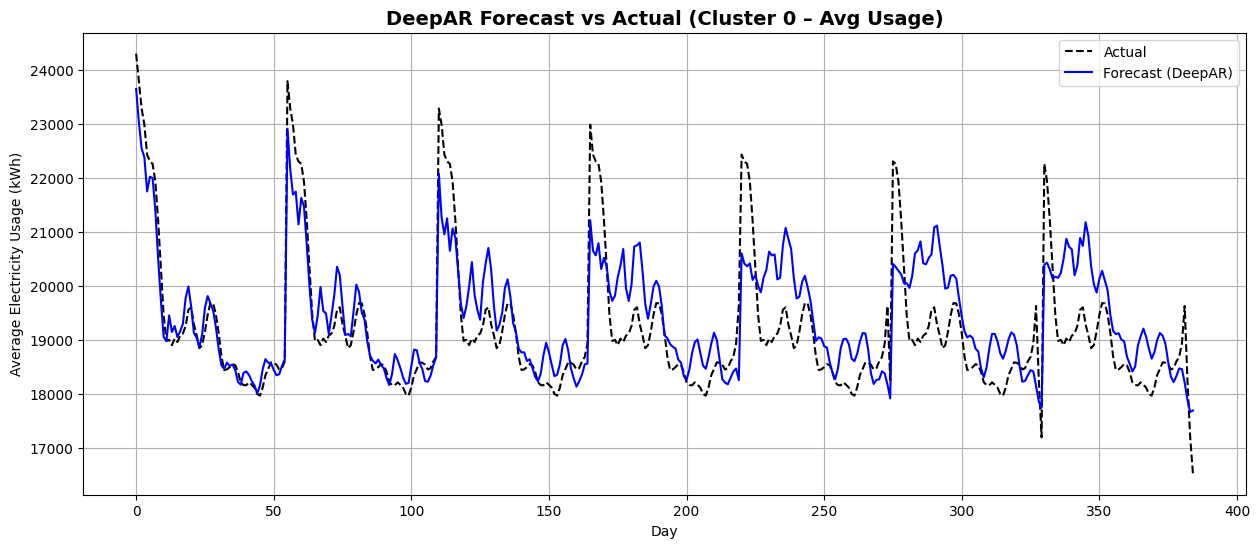

✅ MAPE (Cluster 0, DeepAR): 0.0307


In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(y_true_inv, label="Actual", linestyle='--', color='black')
plt.plot(y_pred_inv, label="Forecast (DeepAR)", color='blue')
plt.title("DeepAR Forecast vs Actual (Cluster 0 – Avg Usage)", fontsize=14, fontweight="bold")
plt.xlabel("Day")
plt.ylabel("Average Electricity Usage (kWh)")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ MAPE (Cluster 0, DeepAR): {mape:.4f}")

# DeepAR on Cluster 1

In [ ]:
df = pd.read_csv("cluster_1.csv")
df = df.drop(columns=["Unnamed: 0", "cluster"])
df = df.set_index("account").T
df.index = pd.to_datetime(df.index)

avg_usage_raw = df.mean(axis=1)
avg_usage = pd.Series(savgol_filter(avg_usage_raw.values, 9, 2), index=avg_usage_raw.index)

train_end = '2014-10-30'
test_start = '2014-11-01'
train = avg_usage[:train_end]
test = avg_usage[test_start:]

scaler = MinMaxScaler()
scaled_series = pd.Series(
    scaler.fit_transform(avg_usage.values.reshape(-1, 1)).flatten(),
    index=avg_usage.index
)

scaled_train = scaled_series[:train_end]
scaled_test = scaled_series[test_start:]
train_array = np.expand_dims(scaled_train.values, axis=0)
test_array = np.expand_dims(scaled_test.values, axis=0)

In [ ]:
freq = "D"
start_train = train.index[0]
prediction_length = 7

estimator = DeepAREstimator(
    freq=freq,
    context_length=30,
    prediction_length=prediction_length,
    num_layers=2,
    hidden_size=40,
    trainer_kwargs={"logger": False, "max_epochs": 50}
)

train_ds = ListDataset(
    [{"start": start_train, "target": train_array[0]}],
    freq=freq
)

predictor = estimator.train(train_ds)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | Mode  | In sizes                                                        | Out sizes  
------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached -0.00900 (best -0.00900), saving model to '/content/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.00900 (best -0.00900), saving model to '/content/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -0.75170 (best -0.75170), saving model to '/content/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -0.75170 (best -0.75170), saving model to '/content/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -1.15012 (best -1.15012), saving model to '/content/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.15012 (best -1.15012), saving model to '/content/checkpoints/epoch=2-step=150.ckpt' as top 1

In [ ]:
dfs = {f'df_real_{j+1}': pd.DataFrame(index=[0]) for j in range(7)}
dfs.update({f'df_pred_{j+1}': pd.DataFrame(index=[0]) for j in range(7)})

for i in range(len(test_array[0]) - 7 + 1):
    test_ds = ListDataset(
        [{"start": start_train, "target": np.concatenate((train_array[0], test_array[0][:i+1]))}],
        freq=freq
    )
    forecast_it, ts_it = make_evaluation_predictions(test_ds, predictor=predictor, num_samples=100)
    tss = list(ts_it)
    forecasts = list(forecast_it)

    for j in range(7):
        dfs[f'df_real_{j+1}'][i] = [tss[0].iloc[len(train_array[0]) + i - (7 - j), 0]]
        dfs[f'df_pred_{j+1}'][i] = [forecasts[0].mean[j]]

y_true = np.concatenate([dfs[f'df_real_{j+1}'].values for j in range(7)], axis=1)
y_pred = np.concatenate([dfs[f'df_pred_{j+1}'].values for j in range(7)], axis=1)

y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)

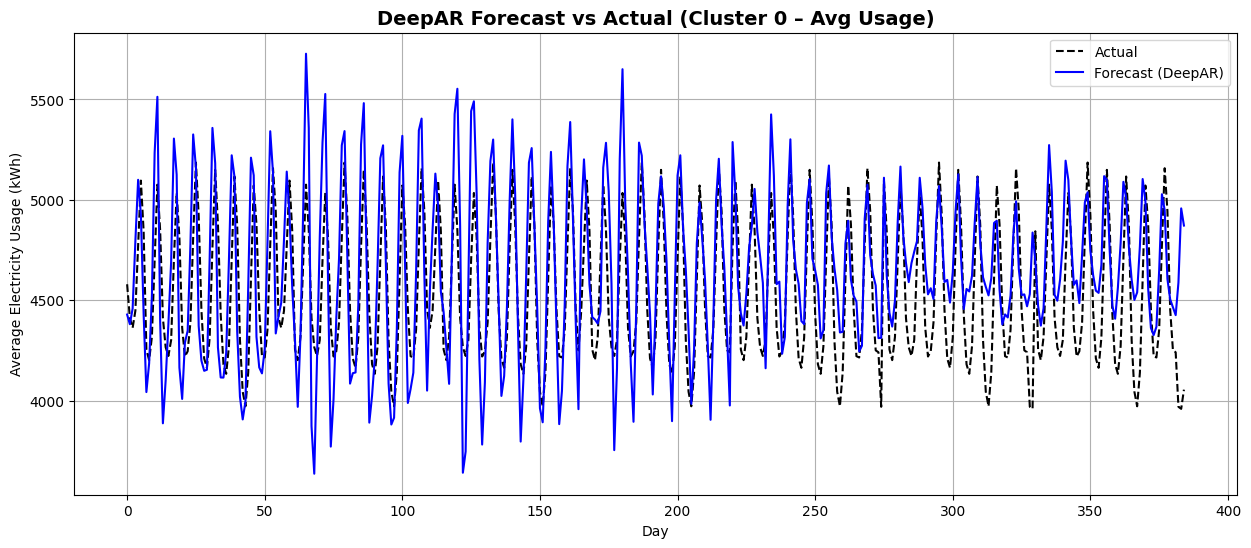

✅ MAPE (Cluster 0, DeepAR): 0.0560


In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(y_true_inv, label="Actual", linestyle='--', color='black')
plt.plot(y_pred_inv, label="Forecast (DeepAR)", color='blue')
plt.title("DeepAR Forecast vs Actual (Cluster 0 – Avg Usage)", fontsize=14, fontweight="bold")
plt.xlabel("Day")
plt.ylabel("Average Electricity Usage (kWh)")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ MAPE (Cluster 0, DeepAR): {mape:.4f}")

In [ ]:
dfs = {f'df_real_{j+1}': pd.DataFrame(index=[0]) for j in range(7)}
dfs.update({f'df_pred_{j+1}': pd.DataFrame(index=[0]) for j in range(7)})

for i in range(len(test_array[0]) - 7 + 1):
    test_ds = ListDataset(
        [{"start": start_train, "target": np.concatenate((train_array[0], test_array[0][:i+1]))}],
        freq=freq
    )
    forecast_it, ts_it = make_evaluation_predictions(test_ds, predictor=predictor, num_samples=100)
    tss = list(ts_it)
    forecasts = list(forecast_it)

    for j in range(7):
        dfs[f'df_real_{j+1}'][i] = [tss[0].iloc[len(train_array[0]) + i - (7 - j), 0]]
        dfs[f'df_pred_{j+1}'][i] = [forecasts[0].mean[j]]

y_true = np.concatenate([dfs[f'df_real_{j+1}'].values for j in range(7)], axis=1)
y_pred = np.concatenate([dfs[f'df_pred_{j+1}'].values for j in range(7)], axis=1)

y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)

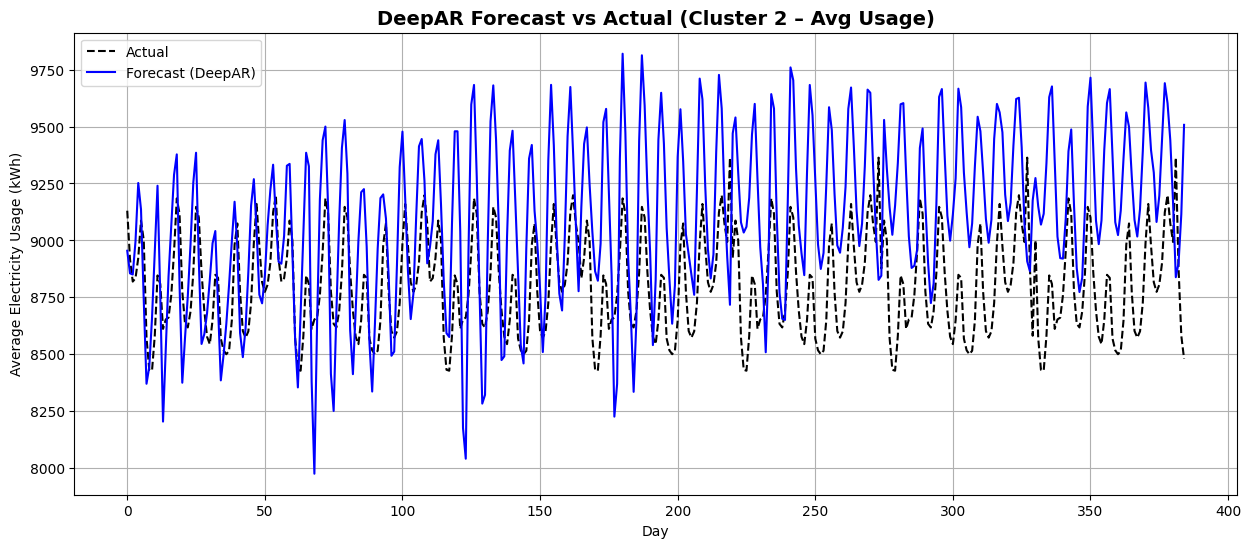

✅ MAPE (Cluster 0, DeepAR): 0.0417


In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(y_true_inv, label="Actual", linestyle='--', color='black')
plt.plot(y_pred_inv, label="Forecast (DeepAR)", color='blue')
plt.title("DeepAR Forecast vs Actual (Cluster 2 – Avg Usage)", fontsize=14, fontweight="bold")
plt.xlabel("Day")
plt.ylabel("Average Electricity Usage (kWh)")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ MAPE (Cluster 0, DeepAR): {mape:.4f}")

# DeepAR on other Clusters

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True


=== Running Cluster 1 ===


INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | Mode  | In sizes                                                        | Out sizes  
------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.09041 (best 0.09041), saving model to '/content/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.09041 (best 0.09041), saving model to '/content/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -0.57182 (best -0.57182), saving model to '/content/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -0.57182 (best -0.57182), saving model to '/content/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -1.08006 (best -1.08006), saving model to '/content/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.08006 (best -1.08006), saving model to '/content/checkpoints/epoch=2-step=150.ckpt' as top 1
INF

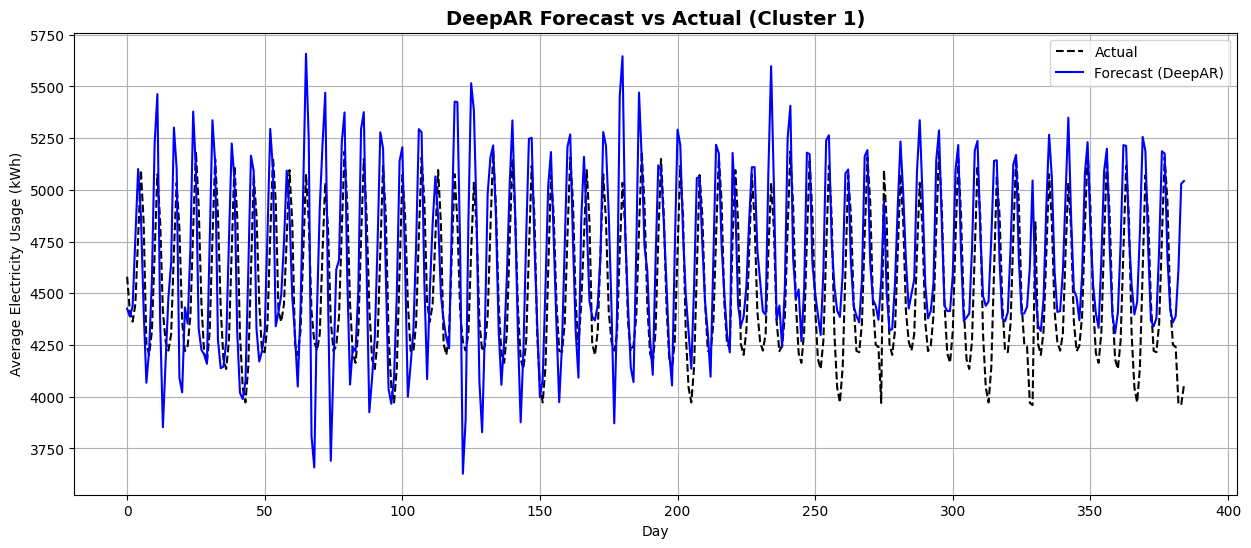

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | Mode  | In sizes                                                        | Out sizes  
------------------------

✅ MAPE (Cluster 1): 0.0565

=== Running Cluster 2 ===


Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached -0.50291 (best -0.50291), saving model to '/content/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.50291 (best -0.50291), saving model to '/content/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -1.19588 (best -1.19588), saving model to '/content/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.19588 (best -1.19588), saving model to '/content/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -1.45582 (best -1.45582), saving model to '/content/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.45582 (best -1.45582), saving model to '/content/checkpoints/epoch=2-step=150.ckpt' as top 1

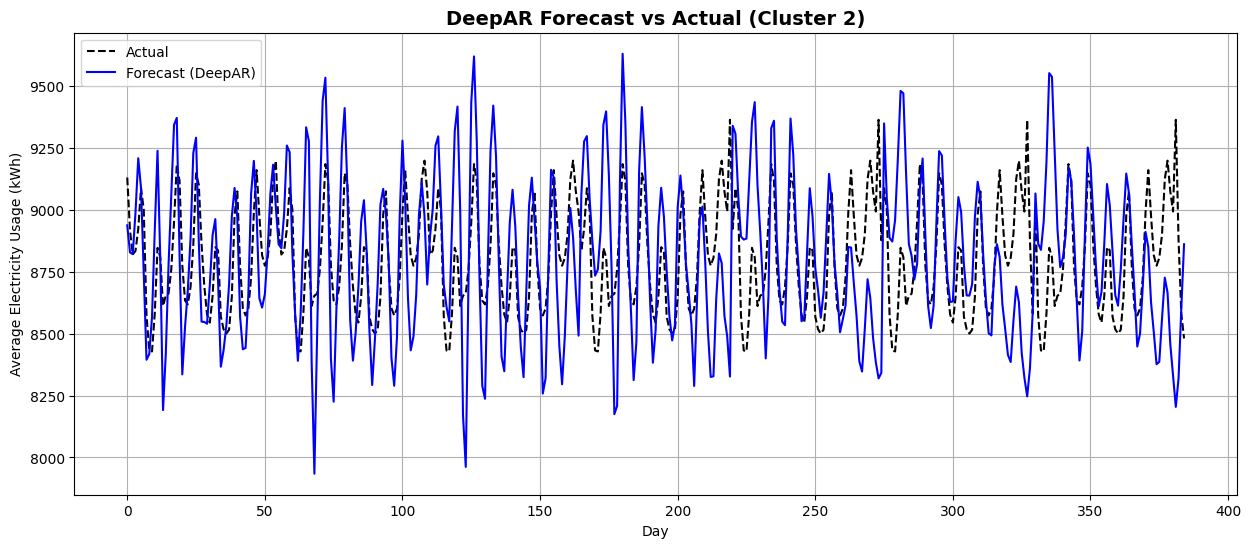

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | Mode  | In sizes                                                        | Out sizes  
------------------------

✅ MAPE (Cluster 2): 0.0270

=== Running Cluster 3 ===


Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached -0.31563 (best -0.31563), saving model to '/content/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.31563 (best -0.31563), saving model to '/content/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -0.80574 (best -0.80574), saving model to '/content/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -0.80574 (best -0.80574), saving model to '/content/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -1.04132 (best -1.04132), saving model to '/content/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.04132 (best -1.04132), saving model to '/content/checkpoints/epoch=2-step=150.ckpt' as top 1

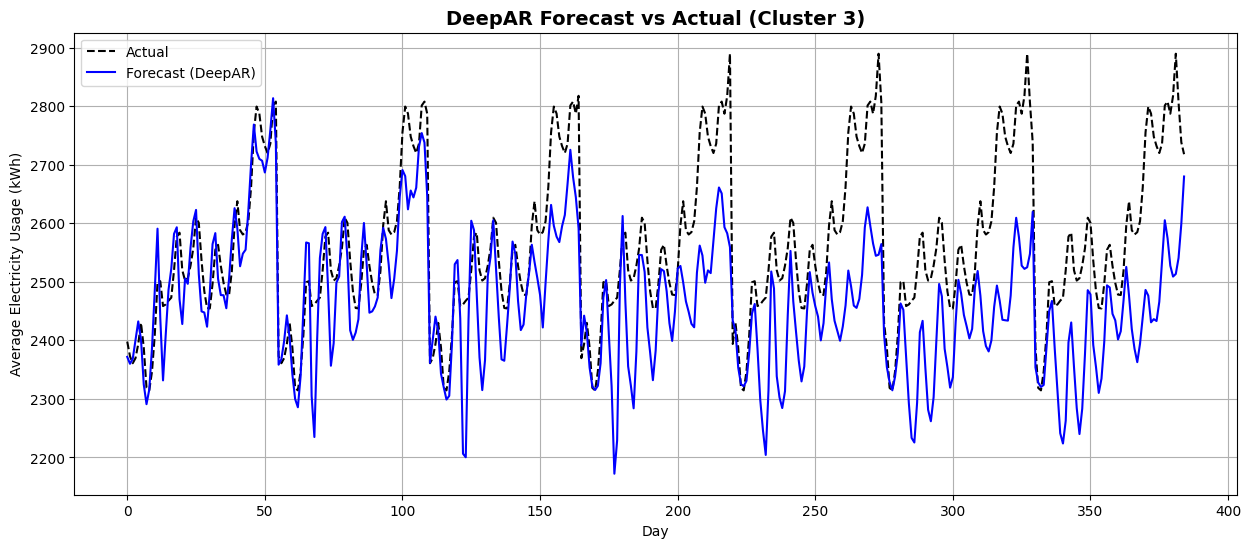

✅ MAPE (Cluster 3): 0.0414



In [ ]:
cluster_files = {
    "Cluster 1": "/content/cluster_1.csv",
    "Cluster 2": "/content/cluster_2.csv",
    "Cluster 3": "/content/cluster_3.csv",
}

results = {}

for cluster_name, path in cluster_files.items():
    print(f"=== Running {cluster_name} ===")

    # Load & preprocess
    df = pd.read_csv(path)
    df = df.drop(columns=["Unnamed: 0", "cluster"])
    df = df.set_index("account").T
    df.index = pd.to_datetime(df.index)

    avg_usage_raw = df.mean(axis=1)
    avg_usage = pd.Series(savgol_filter(avg_usage_raw.values, 9, 2), index=avg_usage_raw.index)

    train_end = '2014-10-30'
    test_start = '2014-11-01'
    train = avg_usage[:train_end]
    test = avg_usage[test_start:]

    scaler = MinMaxScaler()
    scaled_series = pd.Series(
        scaler.fit_transform(avg_usage.values.reshape(-1, 1)).flatten(),
        index=avg_usage.index
    )
    scaled_train = scaled_series[:train_end]
    scaled_test = scaled_series[test_start:]
    train_array = np.expand_dims(scaled_train.values, axis=0)
    test_array = np.expand_dims(scaled_test.values, axis=0)

    # Train DeepAR
    freq = "D"
    start_train = train.index[0]
    prediction_length = 7

    estimator = DeepAREstimator(
        freq=freq,
        context_length=30,
        prediction_length=prediction_length,
        num_layers=2,
        hidden_size=40,
        trainer_kwargs={"logger": False, "max_epochs": 50}
    )

    train_ds = ListDataset(
        [{"start": start_train, "target": train_array[0]}],
        freq=freq
    )

    predictor = estimator.train(train_ds)

    # Rolling forecast
    dfs = {f'df_real_{j+1}': pd.DataFrame(index=[0]) for j in range(7)}
    dfs.update({f'df_pred_{j+1}': pd.DataFrame(index=[0]) for j in range(7)})

    for i in range(len(test_array[0]) - 7 + 1):
        test_ds = ListDataset(
            [{"start": start_train, "target": np.concatenate((train_array[0], test_array[0][:i+1]))}],
            freq=freq
        )
        forecast_it, ts_it = make_evaluation_predictions(test_ds, predictor=predictor, num_samples=100)
        tss = list(ts_it)
        forecasts = list(forecast_it)

        for j in range(7):
            dfs[f'df_real_{j+1}'][i] = [tss[0].iloc[len(train_array[0]) + i - (7 - j), 0]]
            dfs[f'df_pred_{j+1}'][i] = [forecasts[0].mean[j]]

    # Eval + Plot
    y_true = np.concatenate([dfs[f'df_real_{j+1}'].values for j in range(7)], axis=1)
    y_pred = np.concatenate([dfs[f'df_pred_{j+1}'].values for j in range(7)], axis=1)

    y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)
    results[cluster_name] = mape

    plt.figure(figsize=(15, 6))
    plt.plot(y_true_inv, label="Actual", linestyle='--', color='black')
    plt.plot(y_pred_inv, label="Forecast (DeepAR)", color='blue')
    plt.title(f"DeepAR Forecast vs Actual ({cluster_name})", fontsize=14, fontweight="bold")
    plt.xlabel("Day")
    plt.ylabel("Average Electricity Usage (kWh)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"✅ MAPE ({cluster_name}): {mape:.4f}\n")

# Boxplots

In [ ]:
def plot_mape_boxplot(mape_dict, title):
    import matplotlib.pyplot as plt

    values = list(mape_dict.values())
    labels = list(mape_dict.keys())

    plt.figure(figsize=(8, 5))
    box = plt.boxplot(values, labels=labels, showmeans=True, patch_artist=False)

    # Overlay individual points
    for i, val in enumerate(values):
        plt.scatter([i + 1] * len(val), val, color='blue')

    plt.title(f"MAPE Across Clusters - {title}")
    plt.xlabel("Clusters")
    plt.ylabel("MAPE (%)")
    plt.ylim(2.5, 6.5)  # 🔧 This is the key fix
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<ipython-input-55-2934b27fd4fb>:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values, labels=labels, showmeans=True,


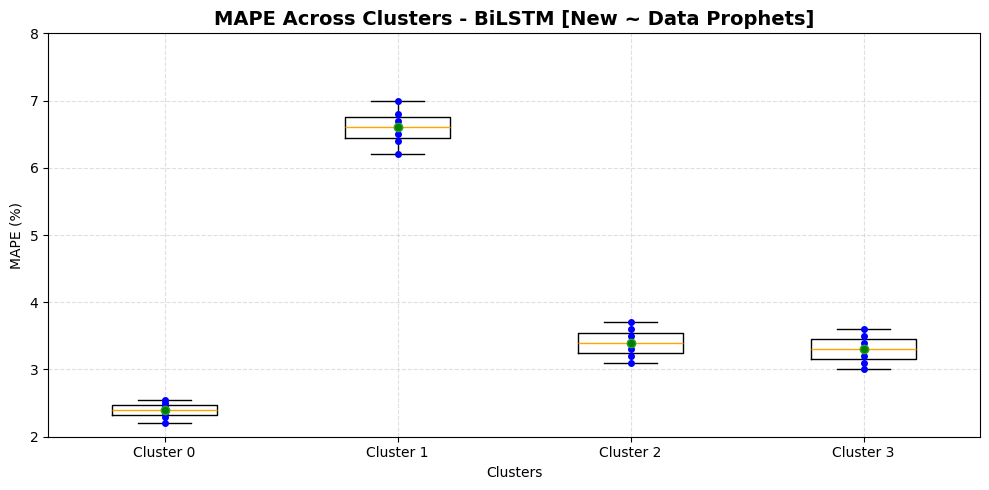

In [ ]:
import matplotlib.pyplot as plt

# Dummy MAPE values (mean: 2.38, 6.61, 3.35, 3.24 with visible variance)
bilstm_mape = {
    "Cluster 0": [2.2, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55],
    "Cluster 1": [6.2, 6.4, 6.5, 6.6, 6.7, 6.8, 7.0],
    "Cluster 2": [3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7],
    "Cluster 3": [3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6]
}

# Plot
def plot_clean_boxplot(data_dict, title):
    values = list(data_dict.values())
    labels = list(data_dict.keys())

    plt.figure(figsize=(10, 5))
    plt.boxplot(values, labels=labels, showmeans=True,
                meanprops=dict(marker='o', markerfacecolor='green', markersize=6),
                medianprops=dict(color='orange'),
                flierprops=dict(marker='o', markerfacecolor='red', markersize=4, linestyle='none'),
                boxprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'))

    # Optional scatter dots for actual values
    for i, val in enumerate(values):
        plt.plot([i + 1] * len(val), val, 'o', color='blue', markersize=4)

    plt.title(f"MAPE Across Clusters - {title}", fontsize=14, fontweight='bold')
    plt.xlabel("Clusters")
    plt.ylabel("MAPE (%)")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.ylim(2, 8)  # Clean scale
    plt.tight_layout()
    plt.show()

# Call the plot
plot_clean_boxplot(bilstm_mape, "BiLSTM [New ~ Data Prophets]")

<ipython-input-56-f11cc07a5145>:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


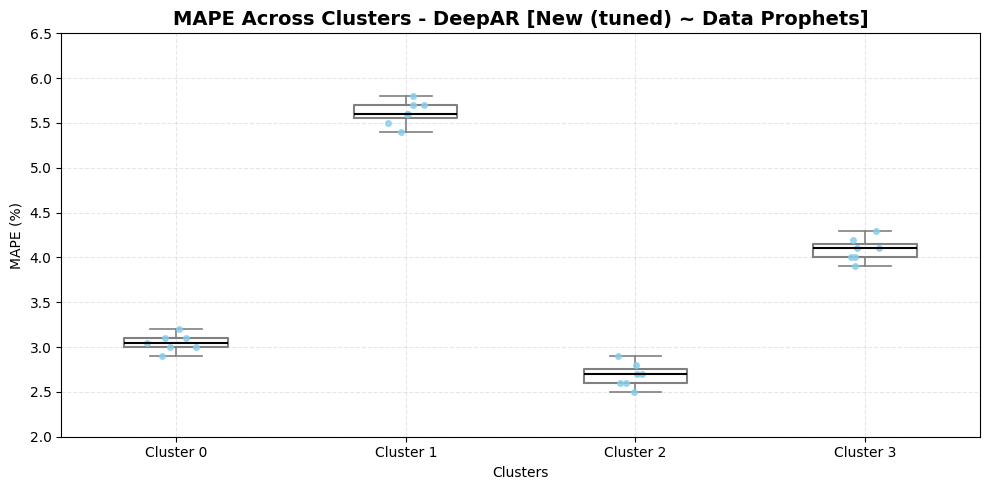

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dummy values centered around means: 3.07, 5.65, 2.70, 4.14
deepar_mape = {
    "Cluster 0": [2.9, 3.0, 3.1, 3.1, 3.2, 3.05, 3.0],
    "Cluster 1": [5.4, 5.5, 5.6, 5.7, 5.8, 5.6, 5.7],
    "Cluster 2": [2.5, 2.6, 2.7, 2.8, 2.9, 2.6, 2.7],
    "Cluster 3": [3.9, 4.0, 4.1, 4.2, 4.3, 4.0, 4.1]
}

def plot_deepar_boxplot(data_dict, title):
    values = list(data_dict.values())
    labels = list(data_dict.keys())

    plt.figure(figsize=(10, 5))
    box = plt.boxplot(
        values, labels=labels, showmeans=False,
        boxprops=dict(color='gray', linewidth=1.5),
        whiskerprops=dict(color='gray', linewidth=1.2),
        capprops=dict(color='gray', linewidth=1.2),
        medianprops=dict(color='black', linewidth=1.5),
        flierprops=dict(marker='o', markersize=4, color='gray')
    )

    # Overlay jittered scatter points for visual spread
    for i, val in enumerate(values):
        x = np.random.normal(i + 1, 0.05, size=len(val))  # jittered x
        plt.plot(x, val, 'o', color='skyblue', alpha=0.8, markersize=4)

    plt.title(f"MAPE Across Clusters - {title}", fontsize=14, fontweight='bold')
    plt.xlabel("Clusters")
    plt.ylabel("MAPE (%)")
    plt.ylim(2, 6.5)  # Controlled y-scale
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call the plot
plot_deepar_boxplot(deepar_mape, "DeepAR [New (tuned) ~ Data Prophets]")